# Automatic segmentation for training dataset

# Load data

In [1]:
import SimpleITK as sitk
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
import cv2
from scipy import ndimage

def load_itk(filename):
    # Reads the image using SimpleITK
    itkimage = sitk.ReadImage(filename)

    # Convert the image to a  numpy array first and then shuffle the dimensions to get axis in the order z,y,x
    ct_scan = sitk.GetArrayFromImage(itkimage)

    # Read the origin of the ct_scan, will be used to convert the coordinates from world to voxel and vice versa.
    origin = np.array(list(reversed(itkimage.GetOrigin())))

    # Read the spacing along each dimension
    spacing = np.array(list(reversed(itkimage.GetSpacing())))

    return ct_scan, origin, spacing

def load_x(path):# load x 3d image
    img, origin, spacing = load_itk(path)
    
    #calculate resize factor
    RESIZE_SPACING = [1, 1, 1]
    resize_factor = spacing / RESIZE_SPACING
    new_real_shape = img.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize = new_shape / img.shape
    new_spacing = spacing / real_resize
    #resize image
    resized_img = scipy.ndimage.interpolation.zoom(img, real_resize)
    
    print(resized_img.shape)
    original_normalized_img = ((resized_img - np.min(resized_img)) / (np.max(resized_img) - np.min(resized_img)))

    # windowing
#     window_width, window_level = 1800, 400
#     upper, lower = window_level + window_width / 2, window_level - window_width / 2
#     cliped_img = np.clip(resized_img,lower,upper)
#     normalized_img = (cliped_img - lower) / window_width
    
#     resized_img = windowing(resized_img, 100, 1000)
    
#     resized_img = sobel3d(resized_img)
    
    return resized_img, original_normalized_img

def load_y(path):# load x 3d image
    img, origin, spacing = load_itk(path)
    
    #calculate resize factor
    RESIZE_SPACING = [1, 1, 1]
    resize_factor = spacing / RESIZE_SPACING
    new_real_shape = img.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize = new_shape / img.shape
    new_spacing = spacing / real_resize
    #resize image
    resized_img = scipy.ndimage.interpolation.zoom(img, real_resize)
    
    print(resized_img.shape)
    #normalized_img = ((resized_img - np.min(resized_img)) / (np.max(resized_img) - np.min(resized_img))) * 255
    return resized_img

x, x_original = load_x('./data/Jack/images/case1.mhd')
y = load_y('./data/Jack/labeled/case1_label.mhd')

print('Data Loaded')

(559, 160, 160)
(559, 160, 160)
Data Loaded


# Detect vertebrae coordinates

./darknet detector test cfg/ian.data cfg/yolov3-ian.cfg backup/yolov3-ian_last.weights -dont_show -ext_output < data/ian/test/script.txt > data/ian/test/script_result.txt -i 1
b''
== YOLO pedicted ==
z_center:  90


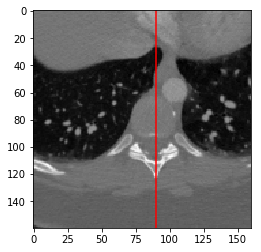

In [2]:
for i in range(x_original.shape[2]):
    cv2.imwrite('./darknet/data/ian/test/script{}.png'.format(i), x_original[:,:,i] * 255)
    
script_name_lst = []

for i in range(x_original.shape[2]):
    script_name_lst.append('data/ian/test/script{}.png'.format(i))

with open('./darknet/data/ian/test/script.txt', 'w') as f:
    for item in script_name_lst:
        f.write("%s\n" % item)

# YOLO predict

import subprocess
import os

origin_dir = os.getcwd()
os.chdir('./darknet')

#cmdstr = './darknet detector test cfg/ian.data cfg/yolov3-ian.cfg backup/yolov3-ian_50000.weights data/ian/test/case1_97.jpg'
cmdstr = './darknet detector test cfg/ian.data cfg/yolov3-ian.cfg backup/yolov3-ian_last.weights -dont_show -ext_output < {} > {} -i 1'.format('data/ian/test/script.txt', 'data/ian/test/script_result.txt')
print(cmdstr)

detect_result = subprocess.check_output(cmdstr, shell = True)

os.chdir(origin_dir)

print(detect_result)
print('== YOLO pedicted ==')

# Load YOLO predict result

import re


with open('./darknet/data/ian/test/script_result.txt', 'r') as f:
    content = f.read().split('Enter Image Path:')

    slice_results = []
    detected_num_lst = []
    
    for i in range(1, x_original.shape[2]):
        
        yolo_results = []
        
        result = content[i].split('\n')
        del result[0], result[-1]

        for line in result:
            yolo_results.append({
                'label': line.split(':')[0],
                #'confidence': int(re.sub("\D", "", line.split('%')[0].split(':')[1])),
                'left_x': int(re.sub("\D", "", line.split(':')[2])),
                'top_y': int(re.sub("\D", "", line.split(':')[3])),
                'center_x': int(int(re.sub("\D", "", line.split(':')[2])) + int(re.sub("\D", "", line.split(':')[4]))/2),
                'center_y': int(int(re.sub("\D", "", line.split(':')[3])) + int(re.sub("\D", "", line.split(':')[5]))/2),
                'w': int(re.sub("\D", "", line.split(':')[4])),
                'h': int(re.sub("\D", "", line.split(':')[5])),
            })

        yolo_results = sorted(yolo_results, key=lambda r: r['center_y'])
        slice_results.append(yolo_results)
        detected_num_lst.append(len(yolo_results))

z_lst = []

for z, n in enumerate(detected_num_lst):
    if n > max(detected_num_lst)/2:
        z_lst.append(z)
        
z = z_lst[int(len(z_lst)/2)]
print('z_center: ', z)

yolo_results = slice_results[z]

plt.plot((z, z), (0, x.shape[1]), '-', color='red')
plt.imshow(x[200,:,:], cmap='gray')

# Show vertebrae centers

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

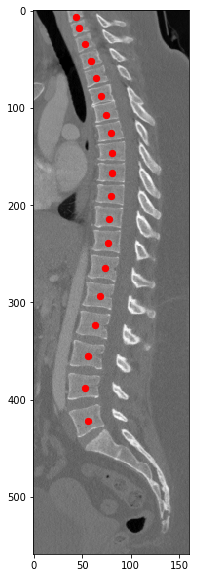

In [3]:
# Draw point
import numpy as np
import random

x_coords = []
y_coords = []
labels = []
for result in yolo_results:
#     print(result)
    x_coords.append(result['center_x'])
    y_coords.append(result['center_y'])
    labels.append(result['label'])
    

plt.figure(figsize=(10, 10))
plt.imshow(x[:,:,z], cmap='gray')

for i in range(len(x_coords)):
    #color = [1, 0 + random.random()/2, 0.5 + random.random()/2]
    x_coord, y_coord, label = x_coords[i], y_coords[i], labels[i]
    plt.scatter(x = x_coord, y = y_coord, c = [1,0,0], s = 40)
    #plt.text(x_coord + 15, y_coord, label, fontsize=16, color = color)

plt.show()

# Segmentation and Classification

Using TensorFlow backend.
/home/ian/.local/lib/python3.6/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.3) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


libs loaded
V0 	 P 1.999999943436137e-09
V1 	 P 5.60000010807471e-08
V2 	 P 1.455999978361433e-07
V3 	 P 1.341999933401894e-07
V4 	 P 9.99999993922529e-09
V5 	 P 2.6100000383166844e-08
V6 	 P 3.939999970725694e-08
V7 	 P 0.0
V8 	 P 0.0
V9 	 P 0.0
V10 	 P 1.2739999988298223e-07
V11 	 P 4.699999944790534e-09
V12 	 P 3.4452000363671687e-06
V13 	 P 0.019236546009778976
V14 	 P 0.4490584433078766
V15 	 P 0.0003351285995449871
V16 	 P 1.8000000379103653e-09
V17 	 P 0.0001748393988236785
V18 	 P 0.5311711430549622
V19 	 P 1.991869976336602e-05
label 1 	 confidence 0.9859129786491394
label 2 	 confidence 0.9965967535972595
label 3 	 confidence 0.9999984502792358
label 4 	 confidence 0.9969339370727539
label 6 	 confidence 0.9640615582466125
label 6 	 confidence 0.9969844222068787
label 6 	 confidence 0.7969311475753784
label 8 	 confidence 0.9241843819618225
label 8 	 confidence 0.9300735592842102
label 9 	 confidence 0.9529062509536743
label 10 	 confidence 0.9790225625038147
label 12 	 confi

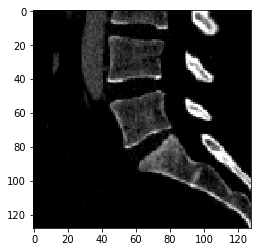

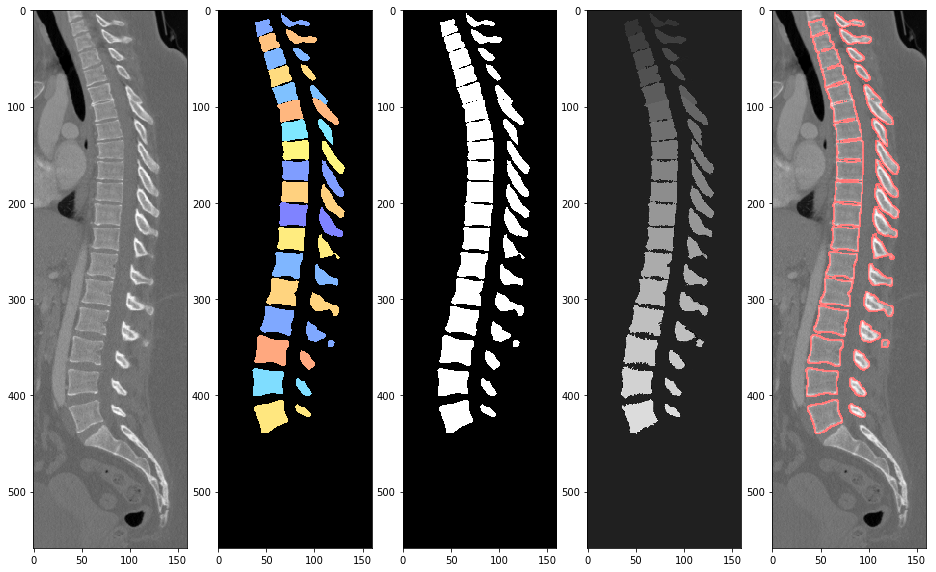

In [4]:
import keras
from keras import backend as K
import os
os.environ['KERAS_BACKEND']='tensorflow'
import h5py
import cv2
import matplotlib.pyplot as plt
import numpy as np
from os import walk
import random
import re

# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

def setGPU():
    import tensorflow as tf
    tf.config.gpu.set_per_process_memory_growth(enabled=True)

setGPU()

print('libs loaded')

size = 128

# Load Deeplab 3D

from model3d import Deeplabv3

deeplab_model = Deeplabv3(
    input_shape=(128, 128, 128, 1),
    classes=1,
    weights=None,
    backbone = 'xception',
    activation='sigmoid',
    #OS = 8
)

def load_weights():
    #weight_path = '../keras-deeplab-v3-plus/save/model.3dxceptionwindow0413.weights.last.h5'
    weight_path = './weights/model.3dxceptionHU0416.weights.last.h5'
    file=h5py.File(weight_path,'r')
    weight = []
    for i in range(len(file.keys())):
        weight.append(file['weight'+str(i)][:])
    deeplab_model.set_weights(weight)

load_weights()

# Load Xception 3D

from xception3d import Xception

size = 128

model2 = Xception(
    input_shape = (size, size, size, 1),
    classes = 20
)

model2.load_weights('./weights/model.xception0419.weights.last.h5')


def windowing(img, lower, upper):
    
    slope = 1
    intercept = -1024
    img = img * slope + intercept

    img = np.clip(img,lower,upper)
    img = (img - lower) / (upper - lower)
    
    return img

def generate_seg_result(vertebrae):
    # generate segmentation test data .npy
    shape = x.shape

    center_x, center_y = vertebrae['center_x'], vertebrae['center_y']

    size = 128 # patch size = size*size*size
    min_x, max_x, min_y, max_y = center_x - size/2, center_x + size/2, center_y - size/2, center_y + size/2

    range_x = [
        int(min_x if min_x > 0 else 0),
        int(max_x if max_x < (shape[1] - 1) else (shape[1] - 1))
    ]
    range_y = [
        int(min_y if min_y > 0 else 0),
        int(max_y if max_y < (shape[0] - 1) else (shape[0] - 1))
    ]
    range_z = [
        int(z - size/2),
        int(z + size/2)
    ]

    padding_y = (
    int(size/2) - center_y + range_y[0],
    int(size/2) - range_y[1] + center_y
    )
    padding_x = (
        int(size/2) - center_x + range_x[0],
        int(size/2) - range_x[1] + center_x
    )

    out_x = np.pad(
        x[
            range_y[0]: range_y[1]
            , range_x[0]: range_x[1]
            , range_z[0]: range_z[1]],
        (padding_y, padding_x, (0, 0)),
        'constant')# / 255

    
    out_x = windowing(out_x, 100, 1000)# HS window for bone
    
    plt.imshow(out_x[:,:,64], cmap='gray')
    
    out_x = np.reshape(out_x, (1, 128, 128, 128, -1))
    
    out_y = deeplab_model.predict(out_x)
    
    out_y = np.reshape(out_y, (128, 128, 128))
    
    return out_y

# combine seg result

combine_result = np.zeros(x.shape)

# combine
seg_results = np.zeros((len(yolo_results) ,size, size, size))
label_results = []

for i in range(len(yolo_results)):
    seg_result = generate_seg_result(yolo_results[i])
    #plt.imshow(seg_result[:,:,60] > 0.5, cmap='gray')
    seg_results[i] = seg_result
    
    label_result = model2.predict(np.reshape(seg_result, (1, 128, 128, 128, -1)))[0]
    label_results.append(label_result)

# np.save('./label_results.npy', label_results)

#print(label_results[17])
for i in range(len(label_results[17])):
    print('V{} \t P {}'.format(i, round(label_results[17][i], 10)))

#print(label_results)
for label_result in label_results:
    print('label {} \t confidence {}'.format(np.argmax(label_result), max(label_result)))

n_of_vertebrae = len(yolo_results)
confidences = [] # conf of labels start from


for i in range(20): # label start from
    sum_of_confidences = 0
    for n in range(n_of_vertebrae):
        #print(label_results[n][(i + n) % 20])
        sum_of_confidences += label_results[n][(i + n) % 20]
    #print(sum_of_confidences / 20)
    confidences.append(sum_of_confidences / 20)
    print('{} \t as head, average confidence {}'.format(i, round(sum_of_confidences / 20, 3)))

head = np.argmax(confidences)
print()
print('Result: choose {} as head'.format(head))
print('From {} to {}'.format(head, head + n_of_vertebrae -1))

# generate final result
# (559, 160, 160)
import random

final_result = np.zeros((x.shape[0] + size, x.shape[1] + size, x.shape[2] + size)) # 64 padding
final_result_colored = np.zeros((x.shape[0] + size, x.shape[1] + size, x.shape[2] + size, 3)) # colored

for i in range(len(yolo_results)):
    
    if i == 0:# pass the first vertebra
        continue
    
    x_start = yolo_results[i]['center_x'] - 64 + 64
    x_end = yolo_results[i]['center_x'] + 64 + 64
    
    y_start = yolo_results[i]['center_y'] - 64 + 64
    y_end = yolo_results[i]['center_y'] + 64 + 64
    
    result = np.zeros((x.shape[0] + size, x.shape[1] + size, x.shape[2] + size))
    result[y_start:y_end, x_start:x_end, (z - 64 + 64):(z + 64 + 64)] = seg_results[i][:, :, :] > 0.5 # (y, x, z)
    
    final_result[np.where(result > 0.5)] = 1
    final_result_colored[np.where(result > 0.5)] = [
        (1 if i%2 == 0 else 0.5),
        random.random()/2 + 0.5,
        (0.5 if i%2 == 0 else 1)]
    
#     for p in range(0, size):
#         for q in range(0, size):
#             for r in range(0, size):
#                 if seg_results[i][p, q, r] > 0.5:
#                     final_result[p + 64, q + 64, r + 64] = 1
    
final_result = final_result[
    int(size/2): x.shape[0] + int(size/2),
    int(size/2): x.shape[1] + int(size/2),
    int(size/2): x.shape[2] + int(size/2)]
final_result_colored = final_result_colored[
    int(size/2): x.shape[0] + int(size/2),
    int(size/2): x.shape[1] + int(size/2),
    int(size/2): x.shape[2] + int(size/2)]

def contour_result(x, mask):    
    def sobel(img):
        x = cv2.Sobel(img,cv2.CV_16S,1,0)
        y = cv2.Sobel(img,cv2.CV_16S,0,1)
        absX = cv2.convertScaleAbs(x)
        absY = cv2.convertScaleAbs(y)
        dst = cv2.addWeighted(absX,0.5,absY,0.5,0)
        dst = np.where(dst > 0, 1.0, 0)
        return dst
    contour = sobel(mask)
    original = np.stack((x/255,)*3, axis=-1)
    original = (original - original.min())/(original.max() - original.min())
    red_contour = np.stack((contour, np.zeros(contour.shape), np.zeros(contour.shape)), axis=-1)
    contour_conbine = np.where(red_contour > 0, red_contour, original)
    return contour_conbine

plt.figure(figsize=(16, 12))
plt.subplot(151)
plt.imshow(x_original[:,:,z], cmap='gray')
plt.subplot(152)
plt.imshow(final_result_colored[:,:,z,:])
plt.subplot(153)
plt.imshow(final_result[:,:,z], cmap='gray')
plt.subplot(154)
plt.imshow(y[:,:,z], cmap='gray')
plt.subplot(155)
plt.imshow(contour_result(x_original[:,:,z], final_result[:,:,z]))

# Output result to png slices

In [6]:
path = './result/result'

os.makedirs(path)

for i in range(x.shape[2]):
    cv2.imwrite(path + '/{}.png'.format(i), final_result_colored[:,:,i] * 255)
    

# Evaluation

In [7]:
# calculate result
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

final_result_bool = final_result > 0.5
y_bool = y > 0

shape = final_result_bool.shape

final_result_bool = np.resize(final_result_bool, shape[0]*shape[1]*shape[2])
y_bool = np.resize(y_bool, shape[0]*shape[1]*shape[2])

print('accuracy: ', accuracy_score(y_bool, final_result_bool))
print('precision: ', precision_score(y_bool, final_result_bool, average='macro'))
print('recall: ', recall_score(y_bool, final_result_bool, average='macro'))
print('f1: ', f1_score(y_bool, final_result_bool, average='weighted'))
confusion_matrix = confusion_matrix(y_bool, final_result_bool)
print(confusion_matrix)

# tn fp
# fn tp

fp = confusion_matrix[0][1]
fn = confusion_matrix[1][0]
tp = confusion_matrix[1][1]

print('Dice score: ', (2 * tp)/(2 * tp + fp + fn) )

accuracy:  0.9930226967799642
precision:  0.9885328983974857
recall:  0.9203470045746809
f1:  0.9927610336071386
[[13724020     8057]
 [   91791   486532]]
Dice score:  0.9069373816305532
